In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
n = 1000
norm_gen = np.random.default_rng(seed=33)
returns = norm_gen.normal(size=n, loc=0, scale=0.001)
prices = 1 * np.exp(np.cumsum(np.log(returns + 1)))
times = pd.date_range('2025-01-01 06:00:00', periods=n, freq='min')
df = pd.DataFrame({'t': times, 'price': prices})

<Axes: xlabel='t'>

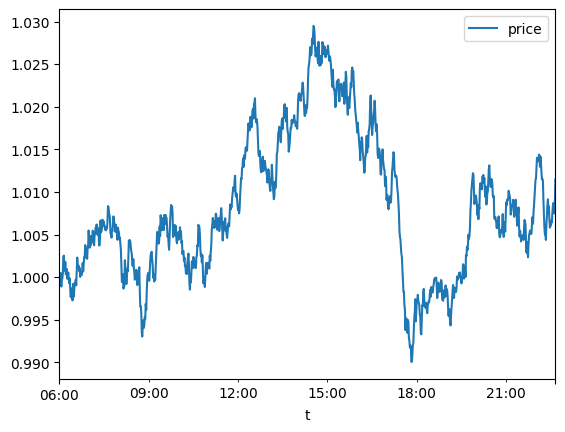

In [3]:
df.plot(x='t', y='price')

In [4]:
signal_df = pd.DataFrame({'t': times, 'signal': norm_gen.choice([-1, 0, 1], p=[0.1, 0.8, 0.1], size=n)})

In [12]:
def backtester(price_df, signal_df):
    """
    Backtester prototype
    Execution strategy: on the first non-zero signal open position until signal sign switch. On signal sign switch open the inverse position instead.
    price_df: ('t', 'price')
    signal_df: ('t', 'signal')
    """
    # Merge prices with signals under condition that the signal timestamp is strictly lower than price timestamp.
    merged_df = pd.merge_asof(price_df, signal_df, on='t', allow_exact_matches=False, direction='backward')
    merged_df['signal'].fillna(0, inplace=True)
    merged_df['position'] = np.sign(merged_df['signal']).replace(0, np.nan).ffill().fillna(0)
    merged_df['trade'] = merged_df['position'].diff(1).fillna(0)
    merged_df['return'] = (merged_df['position'].shift(1) * (merged_df['price'].diff(1) / merged_df['price'].shift(1))).fillna(0)
    merged_df['equity'] = (1 + merged_df['return']).cumprod()
    # When analyzing return/equity values use positions that created those returns, thus the ones from the prev. bar
    merged_df['r_position'] = merged_df['position'].shift(1).fillna(0)
    
    return_df = merged_df[['t', 'r_position', 'return', 'equity']]
    
    trade_df = merged_df.loc[merged_df['trade'].abs() > 0, ['t', 'price', 'trade']]
    return return_df, trade_df

In [13]:
return_df, trade_df = backtester(df, signal_df)

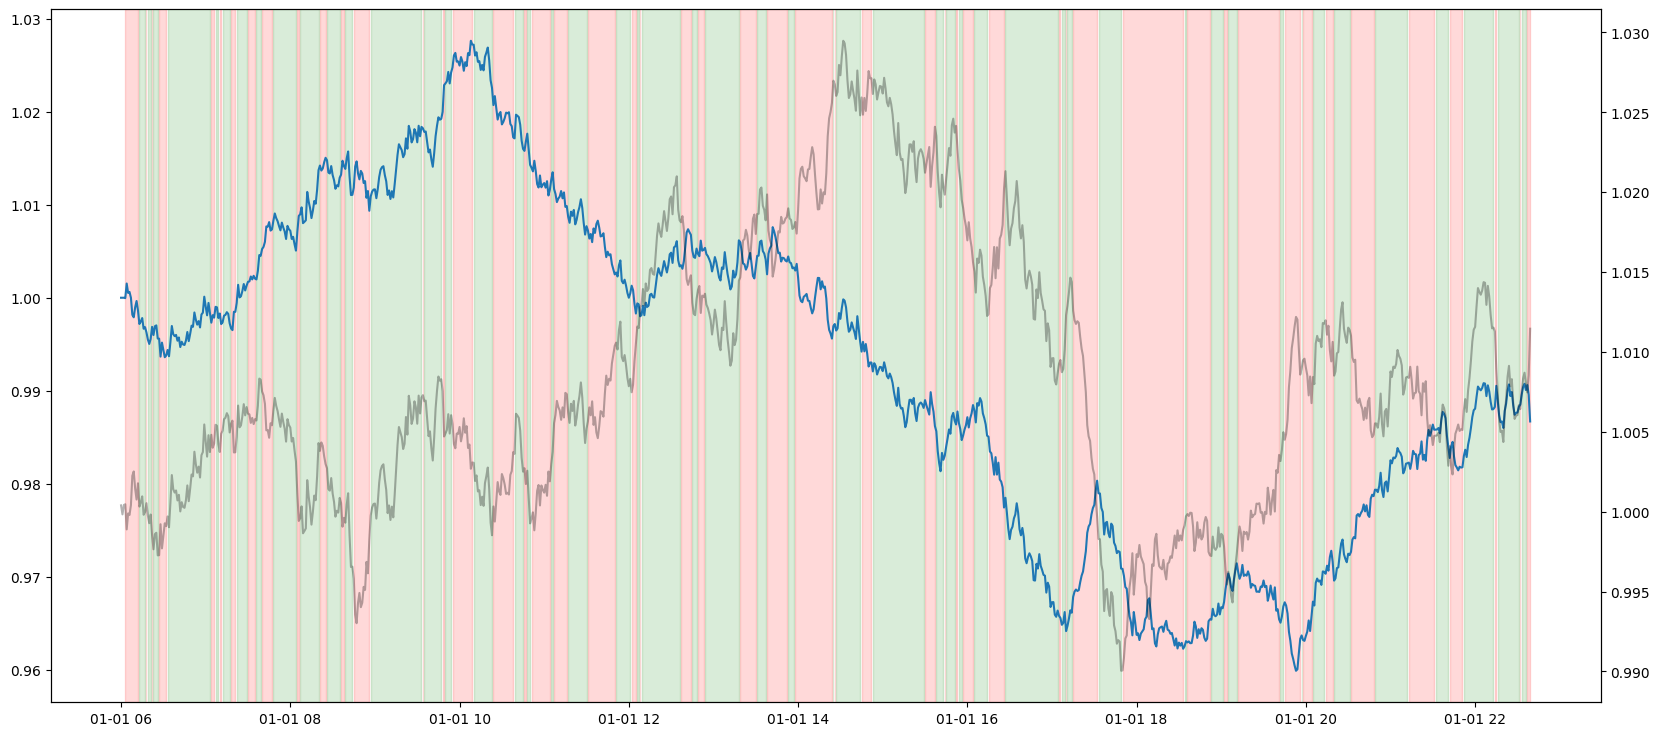

In [14]:
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(return_df['t'], return_df['equity'])
ymin, ymax = ax.get_ylim()
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] > 0), color='green', alpha=0.15)
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] < 0), color='red', alpha=0.15)
ax.set_ylim(ymin, ymax)

ax2 = ax.twinx()
ax2.plot(df['t'], df['price'], c='black', alpha=0.3)